#Data Loading

In [0]:
import numpy as np
import pandas as pd
data_joined = spark.sql("select * from dsci_dev.northwestern.fund_monthly fm NATURAL JOIN dsci_dev.northwestern.categories_of_interest ci NATURAL JOIN dsci_dev.northwestern.fund_metadata fmeta JOIN dsci_dev.northwestern.net_expense_ratios ner ON fmeta.SecId = ner.SecID AND ner.Year = YEAR(fm.MonthEndDate)").toPandas()
data_joined.head()

,SecId,MorningstarCategory,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,MorningstarRating,DeprecatedSince,Interested,Fund,Inception,InvestmentType,Firm,IsActive,SecId,Year,NetExpenseRatio
0,FOUSA00IZ6,US Fund Small Growth,U.S. Equity,2009-12-31,732508264.0,1.225465e+07,0.086643,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,FOUSA00IZ6,2009,1.12
1,FOUSA00IZ6,US Fund Small Growth,U.S. Equity,2010-01-31,718864469.0,1.738047e+07,-0.042359,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,FOUSA00IZ6,2010,1.07
2,FOUSA00IZ6,US Fund Small Growth,U.S. Equity,2010-02-28,761262325.0,5.962445e+06,0.050737,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,FOUSA00IZ6,2010,1.07
3,FOUSA00IZ6,US Fund Small Growth,U.S. Equity,2010-03-31,857004277.0,2.257041e+07,0.096162,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,FOUSA00IZ6,2010,1.07
4,FOUSA00IZ6,US Fund Small Growth,U.S. Equity,2010-04-30,894147565.0,9.733415e+06,0.032003,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,FOUSA00IZ6,2010,1.07


In [0]:
data_joined.MorningstarCategory.value_counts()

MorningstarCategory
US Fund Large Blend                    82907
US Fund Large Growth                   69594
US Fund Large Value                    58599
US Fund Diversified Emerging Mkts      40444
US Fund Foreign Large Blend            38273
                                       ...  
US Fund Digital Assets                   582
US Fund Options-based                    366
US Fund Market Neutral                   295
US Fund Commodities Agriculture           29
US Fund Commodities Precious Metals       15
Name: count, Length: 133, dtype: int64

#Select Moning star Category Here

In [0]:
# print out all categories
old_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
print(data_joined['MorningstarCategory'].value_counts())
pd.set_option('display.max_rows', old_max_rows)

MorningstarCategory
US Fund Large Blend                             82907
US Fund Large Growth                            69594
US Fund Large Value                             58599
US Fund Diversified Emerging Mkts               40444
US Fund Foreign Large Blend                     38273
US Fund Small Blend                             37208
US Fund Moderate Allocation                     33948
US Fund Mid-Cap Growth                          33037
US Fund Small Growth                            32283
US Fund High Yield Bond                         30810
US Fund Mid-Cap Blend                           26446
US Fund Intermediate Core Bond                  25341
US Fund Intermediate Core-Plus Bond             22861
US Fund Short-Term Bond                         22318
US Fund Mid-Cap Value                           21265
US Fund Moderately Conservative Allocation      21121
US Fund Small Value                             21121
US Fund Trading--Leveraged Equity               19200
US Fund 

In [0]:
# Note we filter MorningStarCategory == 'US Fund Small Growth' for now
small_growth = data_joined[data_joined.MorningstarCategory == 'US Fund Small Growth'] # change this to generate dataset for other category
small_growth = small_growth.drop(small_growth.columns[0], axis=1)
small_growth.head()

,MorningstarCategory,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,MorningstarRating,DeprecatedSince,Interested,Fund,Inception,InvestmentType,Firm,IsActive,Year,NetExpenseRatio
0,US Fund Small Growth,U.S. Equity,2009-12-31,732508264.0,1.225465e+07,0.086643,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,2009,1.12
1,US Fund Small Growth,U.S. Equity,2010-01-31,718864469.0,1.738047e+07,-0.042359,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,2010,1.07
2,US Fund Small Growth,U.S. Equity,2010-02-28,761262325.0,5.962445e+06,0.050737,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,2010,1.07
3,US Fund Small Growth,U.S. Equity,2010-03-31,857004277.0,2.257041e+07,0.096162,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,2010,1.07
4,US Fund Small Growth,U.S. Equity,2010-04-30,894147565.0,9.733415e+06,0.032003,4.0,None,Y,Columbia Small Cap Growth Fund,1996-10-01,Open-End Fund,Columbia Threadneedle,1,2010,1.07


#Data Preprocessing

In [0]:
small_growth = small_growth[(small_growth['Interested'] == 'Y') & (small_growth['IsActive'] == 1)]
small_growth=small_growth[['USCategoryGroup','MonthEndDate','AUM','NetFlows','Return','Fund','NetExpenseRatio','MorningstarRating','Inception']]
cleaned_small_growth = small_growth.dropna()
cleaned_small_growth

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception
0,U.S. Equity,2009-12-31,732508264.0,1.225465e+07,0.086643,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01
1,U.S. Equity,2010-01-31,718864469.0,1.738047e+07,-0.042359,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
2,U.S. Equity,2010-02-28,761262325.0,5.962445e+06,0.050737,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
3,U.S. Equity,2010-03-31,857004277.0,2.257041e+07,0.096162,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
4,U.S. Equity,2010-04-30,894147565.0,9.733415e+06,0.032003,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
...,...,...,...,...,...,...,...,...,...
1304789,U.S. Equity,2022-12-31,453645664.0,8.871632e+05,-0.074544,Driehaus Small Cap Growth Fund,0.71,5.0,2017-08-21
1308826,U.S. Equity,2020-09-30,205482944.0,-5.631452e+06,-0.021310,JNL/Vanguard Small Company Growth Fund,0.38,2.0,2017-09-25
1308827,U.S. Equity,2020-10-31,202034418.0,-7.296265e+06,0.018548,JNL/Vanguard Small Company Growth Fund,0.38,2.0,2017-09-25
1308828,U.S. Equity,2020-11-30,226492090.0,-4.128708e+06,0.141726,JNL/Vanguard Small Company Growth Fund,0.38,2.0,2017-09-25


In [0]:
selected=cleaned_small_growth[['MonthEndDate','Fund']]

# Convert MonthEndDate from string to datetime
selected['MonthEndDate'] = pd.to_datetime(selected['MonthEndDate'], format='%Y-%m-%d')

selected

/root/.ipykernel/1544/command-1530143892792173-3319306308:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['MonthEndDate'] = pd.to_datetime(selected['MonthEndDate'], format='%Y-%m-%d')


,MonthEndDate,Fund
0,2009-12-31,Columbia Small Cap Growth Fund
1,2010-01-31,Columbia Small Cap Growth Fund
2,2010-02-28,Columbia Small Cap Growth Fund
3,2010-03-31,Columbia Small Cap Growth Fund
4,2010-04-30,Columbia Small Cap Growth Fund
...,...,...
1304789,2022-12-31,Driehaus Small Cap Growth Fund
1308826,2020-09-30,JNL/Vanguard Small Company Growth Fund
1308827,2020-10-31,JNL/Vanguard Small Company Growth Fund
1308828,2020-11-30,JNL/Vanguard Small Company Growth Fund


In [0]:
from pandas.tseries.offsets import MonthEnd

def select_consecutive_funds(df):
    # Find the latest date in the DataFrame
    latest_date = df['MonthEndDate'].max()
    
    # Calculate the starting point: 36 months before the latest date
    start_date = latest_date - pd.DateOffset(months=35)
    
    # Filter DataFrame for entries from the starting point onwards
    recent_df = df[df['MonthEndDate'] >= start_date]
    
    # Group by 'Fund' and check for each group if they have 36 consecutive records
    valid_funds = []
    fund_counts = recent_df.groupby('Fund').size().reset_index(name='Count')
    for _, row in fund_counts.iterrows():
        if row['Count'] == 36:
            valid_funds.append(row['Fund'])
    
    return valid_funds

funds_with_36_consecutive_months = select_consecutive_funds(selected)
funds_with_36_consecutive_months

['AB Small Cap Growth Portfolio',
 'AMG Frontier Small Cap Growth Fund',
 'AMG GW&K Small/Mid Cap Growth Fund',
 'AMG TimesSquare Small Cap Growth Fund',
 'AQR Small Cap Momentum Style Fund',
 'Adara Smaller Companies Fund',
 'Alger Small Cap Focus Fund',
 'Alger Small Cap Growth Fund',
 'Alger Small Cap Growth Portfolio',
 'Alger SmallCap Growth Institutional Fund',
 'Allspring Discovery Small Cap Growth',
 'Allspring Emerging Growth Fund',
 'Allspring Small Company Growth Fund',
 'American Beacon Stephens Sm Cp Gr Fund',
 'American Century Small Cap Growth Fund',
 'Artisan Small Cap Fund',
 'BNY Mellon Select Managers Sm Cp Gr Fd',
 'BNY Mellon Small Cap Multi-Strategy Fund',
 'Baron Discovery Fund',
 'Baron Small Cap Fund',
 'BlackRock Advantage Small Cap Growth Fd',
 'Brown Advisory Small-Cap Growth Fund',
 'Brown Capital Management Small CompanyFd',
 'Calamos Timpani Small Cap Growth Fund',
 'Carillon Eagle Small Cap Growth Fund',
 'Carillon Scout Small Cap Fund',
 'Champlain Smal

In [0]:
consecutive_small_growth = small_growth[small_growth['Fund'].isin(funds_with_36_consecutive_months)]
consecutive_small_growth

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception
0,U.S. Equity,2009-12-31,7.325083e+08,1.225465e+07,0.086643,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01
1,U.S. Equity,2010-01-31,7.188645e+08,1.738047e+07,-0.042359,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
2,U.S. Equity,2010-02-28,7.612623e+08,5.962445e+06,0.050737,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
3,U.S. Equity,2010-03-31,8.570043e+08,2.257041e+07,0.096162,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
4,U.S. Equity,2010-04-30,8.941476e+08,9.733415e+06,0.032003,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
...,...,...,...,...,...,...,...,...,...
1249151,U.S. Equity,2022-08-31,3.281006e+09,-1.725280e+07,-0.040460,Conestoga Small Cap,0.90,4.0,2002-10-01
1249152,U.S. Equity,2022-09-30,3.003009e+09,-1.185932e+07,-0.081064,Conestoga Small Cap,0.90,3.0,2002-10-01
1249153,U.S. Equity,2022-10-31,3.206689e+09,-1.954838e+07,0.074331,Conestoga Small Cap,0.90,3.0,2002-10-01
1249154,U.S. Equity,2022-11-30,3.308563e+09,-4.157320e+07,0.044760,Conestoga Small Cap,0.90,4.0,2002-10-01


In [0]:
consecutive_small_growth.isna().sum()

USCategoryGroup         0
MonthEndDate            0
AUM                     6
NetFlows               13
Return                  7
Fund                    0
NetExpenseRatio         0
MorningstarRating    1864
Inception               0
dtype: int64

In [0]:
selected_mr = consecutive_small_growth[['MorningstarRating','Fund']]

def select_new_funds(df):
    new_funds = []
    # Group by 'Fund' and calculate the NA counts for each group
    na_counts = df.groupby('Fund')['MorningstarRating'].apply(lambda x: x.isna().sum())
    
    # Iterate over the counts to check if any fund has exactly 36 NA values
    for fund, na_count in na_counts.items():
        if na_count == 36:
            new_funds.append(fund)
    
    return new_funds

new_funds = select_new_funds(selected_mr)
new_funds

['AB Small Cap Growth Portfolio',
 'AMG GW&K Small/Mid Cap Growth Fund',
 'Artisan Small Cap Fund',
 'Baron Small Cap Fund',
 'Calamos Timpani Small Cap Growth Fund',
 'Conestoga Small Cap',
 'Driehaus Micro Cap Growth Fund',
 'Eaton Vance Tax-Managed Small-Cap Fund',
 'Empower Small Cap Growth Fund',
 'Invesco Discovery Fund',
 'Invesco Small Cap Growth Fund',
 'Janus Henderson Triton Fund',
 'Janus Henderson Venture Fund',
 'Loomis Sayles Small Cap Growth Fund',
 'MassMutual Small Cap Growth Eq Fd',
 'Nationwide Geneva Small Cap Growth Fund',
 'Nationwide Small Company Growth Fund',
 'Segall Bryant & Hamill Small Cap Gr Fd',
 'T. Rowe Price Small-Cap Stock Fund',
 'TRP Integrated US Small-Cap Gr Eq',
 'Transamerica Small Cap Growth',
 'Wasatch Core Growth Fund',
 'Wasatch Small Cap Growth Fund®']

In [0]:
def update_new_funds_ratings(df, new_funds):
    # Update 'MorningstarRating' to 0 for all new_funds
    for fund in new_funds:
        df.loc[(df['Fund'] == fund) & (df['MorningstarRating'].isna()), 'MorningstarRating'] = 0
    return df

# Call the function to update the DataFrame
consecutive_small_growth = update_new_funds_ratings(consecutive_small_growth, new_funds)
consecutive_small_growth

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception
0,U.S. Equity,2009-12-31,7.325083e+08,1.225465e+07,0.086643,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01
1,U.S. Equity,2010-01-31,7.188645e+08,1.738047e+07,-0.042359,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
2,U.S. Equity,2010-02-28,7.612623e+08,5.962445e+06,0.050737,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
3,U.S. Equity,2010-03-31,8.570043e+08,2.257041e+07,0.096162,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
4,U.S. Equity,2010-04-30,8.941476e+08,9.733415e+06,0.032003,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01
...,...,...,...,...,...,...,...,...,...
1249151,U.S. Equity,2022-08-31,3.281006e+09,-1.725280e+07,-0.040460,Conestoga Small Cap,0.90,4.0,2002-10-01
1249152,U.S. Equity,2022-09-30,3.003009e+09,-1.185932e+07,-0.081064,Conestoga Small Cap,0.90,3.0,2002-10-01
1249153,U.S. Equity,2022-10-31,3.206689e+09,-1.954838e+07,0.074331,Conestoga Small Cap,0.90,3.0,2002-10-01
1249154,U.S. Equity,2022-11-30,3.308563e+09,-4.157320e+07,0.044760,Conestoga Small Cap,0.90,4.0,2002-10-01


In [0]:
consecutive_small_growth.isna().sum()


USCategoryGroup         0
MonthEndDate            0
AUM                     6
NetFlows               13
Return                  7
Fund                    0
NetExpenseRatio         0
MorningstarRating    1036
Inception               0
dtype: int64

In [0]:
def calculate_morningstar_avg_include_na(df):
    # Ensure 'MonthEndDate' is a datetime column
    df['MonthEndDate'] = pd.to_datetime(df['MonthEndDate'])
    
    # Get the last date in the DataFrame, to determine the 12-month period
    last_date = df['MonthEndDate'].max()
    start_date = last_date - pd.DateOffset(months=12)

    # Filter the DataFrame for the last 12 months, regardless of NA values
    df_last_12_months = df[(df['MonthEndDate'] > start_date) & (df['MonthEndDate'] <= last_date)]

    # Calculate the average rating per fund for the last 12 months, ignoring NA values
    avg_ratings = df_last_12_months.groupby('Fund')['MorningstarRating'].mean().reset_index()
    avg_ratings.columns = ['Fund', 'AvgMorningstarRatingLast12M']

    # Merge the average rating back into the original DataFrame
    df_with_avg = pd.merge(df, avg_ratings, on='Fund', how='left')

    return df_with_avg

# Apply the revised function to calculate the Morningstar Rating average, including NA values
consecutive_small_growth = calculate_morningstar_avg_include_na(consecutive_small_growth)
consecutive_small_growth


/root/.ipykernel/1544/command-1530143892792184-1029240307:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MonthEndDate'] = pd.to_datetime(df['MonthEndDate'])


,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception,AvgMorningstarRatingLast12M
0,U.S. Equity,2009-12-31,7.325083e+08,1.225465e+07,0.086643,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01,3.250000
1,U.S. Equity,2010-01-31,7.188645e+08,1.738047e+07,-0.042359,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000
2,U.S. Equity,2010-02-28,7.612623e+08,5.962445e+06,0.050737,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000
3,U.S. Equity,2010-03-31,8.570043e+08,2.257041e+07,0.096162,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000
4,U.S. Equity,2010-04-30,8.941476e+08,9.733415e+06,0.032003,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000
...,...,...,...,...,...,...,...,...,...,...
16857,U.S. Equity,2022-08-31,3.281006e+09,-1.725280e+07,-0.040460,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333
16858,U.S. Equity,2022-09-30,3.003009e+09,-1.185932e+07,-0.081064,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333
16859,U.S. Equity,2022-10-31,3.206689e+09,-1.954838e+07,0.074331,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333
16860,U.S. Equity,2022-11-30,3.308563e+09,-4.157320e+07,0.044760,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333


In [0]:
consecutive_small_growth['MonthEndDate'] = pd.to_datetime(consecutive_small_growth['MonthEndDate'])
consecutive_small_growth['Inception'] = pd.to_datetime(consecutive_small_growth['Inception'])

# Group by 'Fund' and calculate the longevity for each fund
fund_longevity = consecutive_small_growth.groupby('Fund').apply(
    lambda x: (x['MonthEndDate'].max() - x['Inception'].min()).days
).rename('Longevity')

print(fund_longevity.dtype)

# Join the longevity back to the original DataFrame on the 'Fund' column
consecutive_small_growth = consecutive_small_growth.join(
    fund_longevity,
    on='Fund'
)

# The 'Longevity' column is now added to each row of the original DataFrame, showing the longevity of its fund
consecutive_small_growth



int64


,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception,AvgMorningstarRatingLast12M,Longevity
0,U.S. Equity,2009-12-31,7.325083e+08,1.225465e+07,0.086643,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01,3.250000,9587
1,U.S. Equity,2010-01-31,7.188645e+08,1.738047e+07,-0.042359,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587
2,U.S. Equity,2010-02-28,7.612623e+08,5.962445e+06,0.050737,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587
3,U.S. Equity,2010-03-31,8.570043e+08,2.257041e+07,0.096162,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587
4,U.S. Equity,2010-04-30,8.941476e+08,9.733415e+06,0.032003,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587
...,...,...,...,...,...,...,...,...,...,...,...
16857,U.S. Equity,2022-08-31,3.281006e+09,-1.725280e+07,-0.040460,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396
16858,U.S. Equity,2022-09-30,3.003009e+09,-1.185932e+07,-0.081064,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396
16859,U.S. Equity,2022-10-31,3.206689e+09,-1.954838e+07,0.074331,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396
16860,U.S. Equity,2022-11-30,3.308563e+09,-4.157320e+07,0.044760,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396


In [0]:
# Group by 'Fund' and calculate the sum of 'AUM' for each fund
fund_aum_sum = consecutive_small_growth.groupby('Fund')['AUM'].sum()

# Map the summed AUM back onto the original DataFrame to create a new 'SumAUM' column
consecutive_small_growth['SumAUM'] = consecutive_small_growth['Fund'].map(fund_aum_sum)
# Group by 'Fund' and calculate the sum of 'NetFlows' for each fund
fund_netflows_sum = consecutive_small_growth.groupby('Fund')['NetFlows'].sum()

# Map the summed NetFlows back onto the original DataFrame to create a new 'SumNetFlows' column
consecutive_small_growth['SumNetFlows'] = consecutive_small_growth['Fund'].map(fund_netflows_sum)

# The 'SumAUM' column now contains the sum of 'AUM' for each fund across all rows where that fund appears
consecutive_small_growth

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows
0,U.S. Equity,2009-12-31,7.325083e+08,1.225465e+07,0.086643,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08
1,U.S. Equity,2010-01-31,7.188645e+08,1.738047e+07,-0.042359,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08
2,U.S. Equity,2010-02-28,7.612623e+08,5.962445e+06,0.050737,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08
3,U.S. Equity,2010-03-31,8.570043e+08,2.257041e+07,0.096162,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08
4,U.S. Equity,2010-04-30,8.941476e+08,9.733415e+06,0.032003,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16857,U.S. Equity,2022-08-31,3.281006e+09,-1.725280e+07,-0.040460,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09
16858,U.S. Equity,2022-09-30,3.003009e+09,-1.185932e+07,-0.081064,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09
16859,U.S. Equity,2022-10-31,3.206689e+09,-1.954838e+07,0.074331,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09
16860,U.S. Equity,2022-11-30,3.308563e+09,-4.157320e+07,0.044760,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09


In [0]:
# Ensure 'MonthlyReturn' is expressed as a decimal
# Assuming 'MonthlyReturn' is in the dataset as a percentage (5% as 5)
consecutive_small_growth['Return'] = consecutive_small_growth['Return'] / 100

# Calculate the annualized return given a period
def annualized_return(returns, periods_per_year):
    # The product of (1 + monthly returns) over the given period
    compounded_return = (1 + returns).prod()
    # Annualize the return
    return compounded_return ** (periods_per_year / len(returns)) - 1

# Apply the function over rolling windows of 12, 36 months
# Here we group by 'Fund' if we assume there could be data from multiple funds
for window, period_name in zip([12, 36], ['1Yr', '3Yr']):
    consecutive_small_growth[f'Annualized{period_name}Return'] = consecutive_small_growth.groupby('Fund')['Return'] \
        .rolling(window=window).apply(lambda x: annualized_return(x, 12), raw=True) \
        .reset_index(level=0, drop=True)

# Now the DataFrame will have new columns: 'Annualized1YrReturn', 'Annualized3YrReturn'
consecutive_small_growth

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,Annualized1YrReturn,Annualized3YrReturn
0,U.S. Equity,2009-12-31,7.325083e+08,1.225465e+07,0.000866,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN
1,U.S. Equity,2010-01-31,7.188645e+08,1.738047e+07,-0.000424,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN
2,U.S. Equity,2010-02-28,7.612623e+08,5.962445e+06,0.000507,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN
3,U.S. Equity,2010-03-31,8.570043e+08,2.257041e+07,0.000962,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN
4,U.S. Equity,2010-04-30,8.941476e+08,9.733415e+06,0.000320,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16857,U.S. Equity,2022-08-31,3.281006e+09,-1.725280e+07,-0.000405,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.002445,0.000747
16858,U.S. Equity,2022-09-30,3.003009e+09,-1.185932e+07,-0.000811,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.003089,0.000524
16859,U.S. Equity,2022-10-31,3.206689e+09,-1.954838e+07,0.000743,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.002883,0.000826
16860,U.S. Equity,2022-11-30,3.308563e+09,-4.157320e+07,0.000448,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.002267,0.000766


In [0]:
# Function to calculate the rolling standard deviation and its percentile within its category
def calculate_std_dev_percentile(df, periods):
    # Ensure 'MonthEndDate' is a datetime column if not already done
    if not pd.api.types.is_datetime64_any_dtype(df['MonthEndDate']):
        df['MonthEndDate'] = pd.to_datetime(df['MonthEndDate'])
    
    # Calculate standard deviation over specified periods and determine percentile ranks
    for period in periods:
        # Create a column name for the rolling standard deviation
        std_dev_col = f'StdDev_{period}Y'
        
        # Calculate rolling standard deviation for the period (assuming monthly data)
        df[std_dev_col] = df.groupby('Fund')['Return'].transform(lambda x: x.rolling(window=period*12, min_periods=1).std())
        
        # Create a column name for the percentile
        percentile_col = f'StdDev_Percentile_{period}Y'
        
        # Calculate percentiles within each category
        df[percentile_col] = df.groupby('USCategoryGroup')[std_dev_col].rank(pct=True)

    # The function now returns the updated DataFrame with new columns for standard deviation and percentiles
    return df

# Define periods to calculate for (1, 3)
periods = [1, 3]

consecutive_small_growth = calculate_std_dev_percentile(consecutive_small_growth, periods)
consecutive_small_growth

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,Annualized1YrReturn,Annualized3YrReturn,StdDev_1Y,StdDev_Percentile_1Y,StdDev_3Y,StdDev_Percentile_3Y
0,U.S. Equity,2009-12-31,7.325083e+08,1.225465e+07,0.000866,Columbia Small Cap Growth Fund,1.12,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN,NaN,NaN,NaN,NaN
1,U.S. Equity,2010-01-31,7.188645e+08,1.738047e+07,-0.000424,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN,0.000912,0.954643,0.000912,0.980399
2,U.S. Equity,2010-02-28,7.612623e+08,5.962445e+06,0.000507,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN,0.000666,0.723079,0.000666,0.732879
3,U.S. Equity,2010-03-31,8.570043e+08,2.257041e+07,0.000962,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN,0.000632,0.676646,0.000632,0.662484
4,U.S. Equity,2010-04-30,8.941476e+08,9.733415e+06,0.000320,Columbia Small Cap Growth Fund,1.07,4.0,1996-10-01,3.250000,9587,1.785163e+11,1.615771e+08,NaN,NaN,0.000552,0.554858,0.000552,0.529341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16857,U.S. Equity,2022-08-31,3.281006e+09,-1.725280e+07,-0.000405,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.002445,0.000747,0.000617,0.654476,0.000624,0.647365
16858,U.S. Equity,2022-09-30,3.003009e+09,-1.185932e+07,-0.000811,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.003089,0.000524,0.000641,0.691048,0.000640,0.679634
16859,U.S. Equity,2022-10-31,3.206689e+09,-1.954838e+07,0.000743,Conestoga Small Cap,0.90,3.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.002883,0.000826,0.000667,0.724573,0.000649,0.698518
16860,U.S. Equity,2022-11-30,3.308563e+09,-4.157320e+07,0.000448,Conestoga Small Cap,0.90,4.0,2002-10-01,3.833333,7396,2.190829e+11,1.396632e+09,-0.002267,0.000766,0.000696,0.765985,0.000646,0.691466


In [0]:
#  Mark - number of fund
consecutive_small_growth['MonthEndDate'] = pd.to_datetime(consecutive_small_growth['MonthEndDate'])
sorted_groups = consecutive_small_growth.groupby('Fund')
sorted_groups.size()

Fund
AB Small Cap Growth Portfolio               91
AMG Frontier Small Cap Growth Fund         168
AMG GW&K Small/Mid Cap Growth Fund         139
AMG TimesSquare Small Cap Growth Fund      168
AQR Small Cap Momentum Style Fund          128
                                          ... 
Wasatch Small Cap Growth Fund®              83
WesMark Small Company Fund                 168
William Blair Small Cap Growth Fund        168
Wilshire Small Company Growth Portfolio    168
abrdn US Small Cap Equity Fund             110
Length: 121, dtype: int64

In [0]:
consecutive_small_growth['MonthEndDate'] = pd.to_datetime(consecutive_small_growth['MonthEndDate'])

# Group by 'Fund' and get the index of the most recent 'MonthEndDate' for each fund
idx = consecutive_small_growth.groupby('Fund')['MonthEndDate'].idxmax()

# Select the most recent rows for each fund
most_recent_rows = consecutive_small_growth.loc[idx]
most_recent_rows= most_recent_rows.dropna()
most_recent_rows

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,Annualized1YrReturn,Annualized3YrReturn,StdDev_1Y,StdDev_Percentile_1Y,StdDev_3Y,StdDev_Percentile_3Y
15217,U.S. Equity,2022-12-31,3.741751e+09,-9.711233e+07,-0.000603,AB Small Cap Growth Portfolio,0.76,3.0,1969-02-12,3.583333,19680,2.352477e+11,2.172774e+09,-0.004461,0.000460,0.000790,0.881977,0.000773,0.939226
1700,U.S. Equity,2022-12-31,2.669554e+07,2.743296e+06,-0.000661,AMG Frontier Small Cap Growth Fund,0.94,3.0,1997-09-24,3.666667,9229,6.528369e+09,-7.851459e+07,-0.002080,0.001213,0.000751,0.843433,0.000861,0.974364
12059,U.S. Equity,2022-12-31,3.139509e+07,1.326032e+05,-0.000526,AMG GW&K Small/Mid Cap Growth Fund,0.86,4.0,2010-11-03,3.666667,4441,9.701862e+09,-1.233059e+07,-0.002209,0.001160,0.000707,0.782539,0.000708,0.832317
3166,U.S. Equity,2022-12-31,2.285887e+08,-2.522763e+07,-0.000579,AMG TimesSquare Small Cap Growth Fund,0.97,3.0,2000-01-21,2.583333,8380,1.331987e+11,-1.525047e+09,-0.002694,0.000574,0.000756,0.848392,0.000781,0.946098
9085,U.S. Equity,2022-12-31,2.113502e+08,-4.017898e+06,-0.000587,AQR Small Cap Momentum Style Fund,0.60,3.0,2009-07-09,2.500000,4923,3.645503e+10,-1.973651e+08,-0.001798,0.000876,0.000807,0.896259,0.000771,0.936895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14625,U.S. Equity,2022-12-31,1.964314e+09,-4.188961e+07,-0.000565,Wasatch Small Cap Growth Fund®,1.05,2.0,1986-12-08,3.250000,13172,1.815240e+11,-1.042864e+09,-0.004700,0.000421,0.000753,0.845763,0.000837,0.969224
2494,U.S. Equity,2022-12-31,9.497347e+07,9.502704e+05,-0.000526,WesMark Small Company Fund,1.24,3.0,1993-12-31,3.333333,10592,1.474057e+10,1.024386e+06,-0.002022,0.001249,0.000687,0.754631,0.000689,0.789650
1532,U.S. Equity,2022-12-31,5.292675e+08,-2.985949e+06,-0.000498,William Blair Small Cap Growth Fund,1.25,5.0,1999-12-27,4.250000,8405,9.701512e+10,-8.660315e+08,-0.002077,0.001039,0.000743,0.834230,0.000754,0.919147
1080,U.S. Equity,2022-12-31,2.246833e+07,-7.343363e+05,-0.000633,Wilshire Small Company Growth Portfolio,1.09,3.0,1992-10-01,3.000000,11048,5.038910e+09,-1.869129e+07,-0.003420,0.000335,0.000720,0.801482,0.000735,0.889865


In [0]:

# Calculate percentile ranks for each of the annualized return columns
most_recent_rows['PercentileRank1YrReturn'] = most_recent_rows['Annualized1YrReturn'].rank(pct=True)
most_recent_rows['PercentileRank3YrReturn'] = most_recent_rows['Annualized3YrReturn'].rank(pct=True)


# Convert percentile rank to a more typical percentage form, if necessary
most_recent_rows['PercentileRank1YrReturn'] *= 100
most_recent_rows['PercentileRank3YrReturn'] *= 100


# The 'most_recent_rows' DataFrame now contains new columns with the percentile rank for each return period
most_recent_rows

,USCategoryGroup,MonthEndDate,AUM,NetFlows,Return,Fund,NetExpenseRatio,MorningstarRating,Inception,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,Annualized1YrReturn,Annualized3YrReturn,StdDev_1Y,StdDev_Percentile_1Y,StdDev_3Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn
15217,U.S. Equity,2022-12-31,3.741751e+09,-9.711233e+07,-0.000603,AB Small Cap Growth Portfolio,0.76,3.0,1969-02-12,3.583333,19680,2.352477e+11,2.172774e+09,-0.004461,0.000460,0.000790,0.881977,0.000773,0.939226,4.132231,21.487603
1700,U.S. Equity,2022-12-31,2.669554e+07,2.743296e+06,-0.000661,AMG Frontier Small Cap Growth Fund,0.94,3.0,1997-09-24,3.666667,9229,6.528369e+09,-7.851459e+07,-0.002080,0.001213,0.000751,0.843433,0.000861,0.974364,85.123967,90.909091
12059,U.S. Equity,2022-12-31,3.139509e+07,1.326032e+05,-0.000526,AMG GW&K Small/Mid Cap Growth Fund,0.86,4.0,2010-11-03,3.666667,4441,9.701862e+09,-1.233059e+07,-0.002209,0.001160,0.000707,0.782539,0.000708,0.832317,81.818182,88.429752
3166,U.S. Equity,2022-12-31,2.285887e+08,-2.522763e+07,-0.000579,AMG TimesSquare Small Cap Growth Fund,0.97,3.0,2000-01-21,2.583333,8380,1.331987e+11,-1.525047e+09,-0.002694,0.000574,0.000756,0.848392,0.000781,0.946098,58.677686,33.884298
9085,U.S. Equity,2022-12-31,2.113502e+08,-4.017898e+06,-0.000587,AQR Small Cap Momentum Style Fund,0.60,3.0,2009-07-09,2.500000,4923,3.645503e+10,-1.973651e+08,-0.001798,0.000876,0.000807,0.896259,0.000771,0.936895,92.561983,73.553719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14625,U.S. Equity,2022-12-31,1.964314e+09,-4.188961e+07,-0.000565,Wasatch Small Cap Growth Fund®,1.05,2.0,1986-12-08,3.250000,13172,1.815240e+11,-1.042864e+09,-0.004700,0.000421,0.000753,0.845763,0.000837,0.969224,3.305785,18.181818
2494,U.S. Equity,2022-12-31,9.497347e+07,9.502704e+05,-0.000526,WesMark Small Company Fund,1.24,3.0,1993-12-31,3.333333,10592,1.474057e+10,1.024386e+06,-0.002022,0.001249,0.000687,0.754631,0.000689,0.789650,88.429752,93.388430
1532,U.S. Equity,2022-12-31,5.292675e+08,-2.985949e+06,-0.000498,William Blair Small Cap Growth Fund,1.25,5.0,1999-12-27,4.250000,8405,9.701512e+10,-8.660315e+08,-0.002077,0.001039,0.000743,0.834230,0.000754,0.919147,85.950413,85.950413
1080,U.S. Equity,2022-12-31,2.246833e+07,-7.343363e+05,-0.000633,Wilshire Small Company Growth Portfolio,1.09,3.0,1992-10-01,3.000000,11048,5.038910e+09,-1.869129e+07,-0.003420,0.000335,0.000720,0.801482,0.000735,0.889865,24.793388,13.223140


In [0]:
from matplotlib import pyplot as plt 
import seaborn as sns


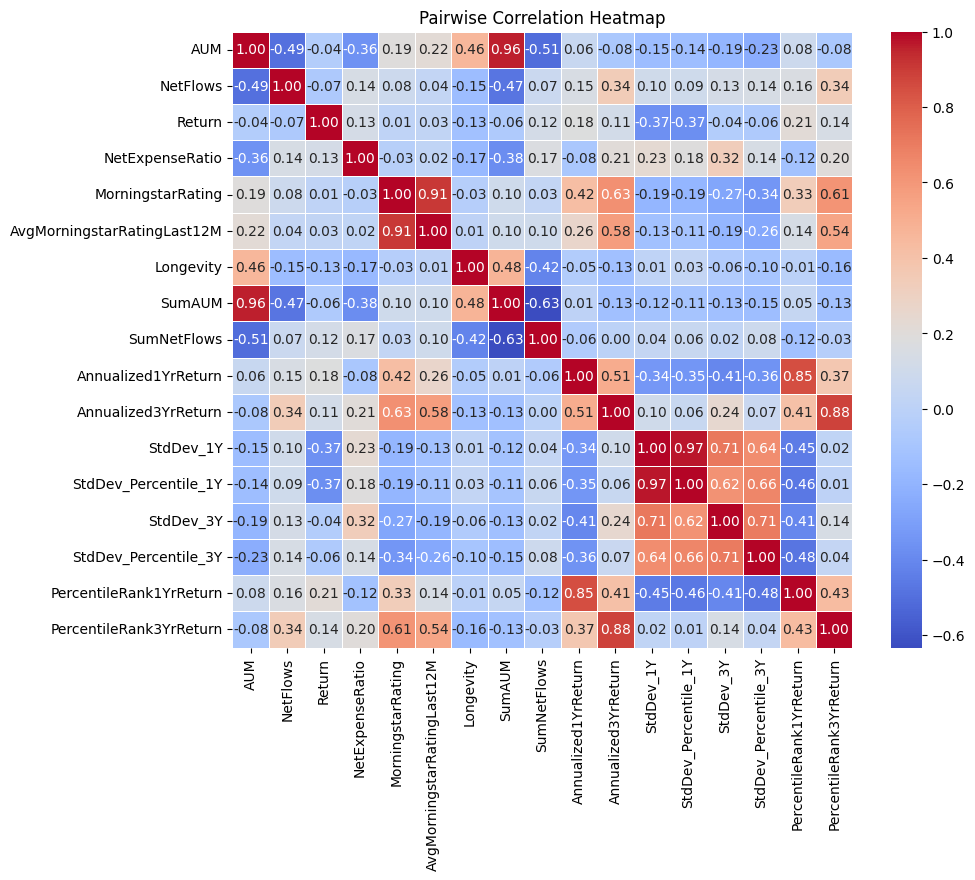

In [0]:
# Create a new DataFrame by dropping specified columns
dataset_without_corr = most_recent_rows.drop(columns=['Inception', 'MonthEndDate', 'USCategoryGroup','Fund'])

# Calculate the correlation matrix for the new DataFrame
correlation_matrix = dataset_without_corr.corr()

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pairwise Correlation Heatmap')
plt.show()


In [0]:
# Drop the specified columns for multicollinearity
dataset_without_corr = most_recent_rows.drop(columns=['Annualized1YrReturn', 'Annualized3YrReturn','StdDev_1Y','StdDev_3Y','MorningstarRating','AUM','Inception','MonthEndDate', 'USCategoryGroup','Fund'])


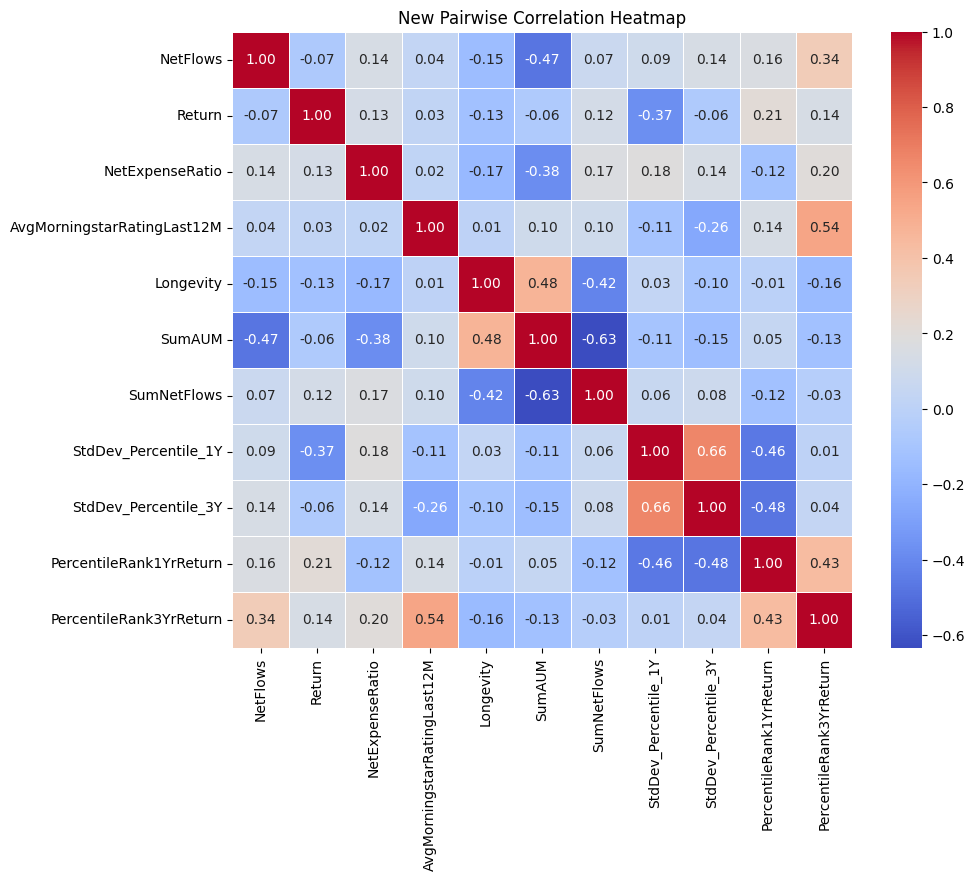

In [0]:
correlation_matrix1 = dataset_without_corr.corr()

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('New Pairwise Correlation Heatmap')
plt.show()

In [0]:
dataset_for_clustering = most_recent_rows.drop(columns=['Annualized1YrReturn', 'Annualized3YrReturn','StdDev_1Y','StdDev_3Y','MorningstarRating','AUM','Inception','MonthEndDate', 'USCategoryGroup'])
dataset_for_clustering.head()

,NetFlows,Return,Fund,NetExpenseRatio,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,StdDev_Percentile_1Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn
15217,-9.711233e+07,-0.000603,AB Small Cap Growth Portfolio,0.76,3.583333,19680,2.352477e+11,2.172774e+09,0.881977,0.939226,4.132231,21.487603
1700,2.743296e+06,-0.000661,AMG Frontier Small Cap Growth Fund,0.94,3.666667,9229,6.528369e+09,-7.851459e+07,0.843433,0.974364,85.123967,90.909091
12059,1.326032e+05,-0.000526,AMG GW&K Small/Mid Cap Growth Fund,0.86,3.666667,4441,9.701862e+09,-1.233059e+07,0.782539,0.832317,81.818182,88.429752
3166,-2.522763e+07,-0.000579,AMG TimesSquare Small Cap Growth Fund,0.97,2.583333,8380,1.331987e+11,-1.525047e+09,0.848392,0.946098,58.677686,33.884298
9085,-4.017898e+06,-0.000587,AQR Small Cap Momentum Style Fund,0.60,2.500000,4923,3.645503e+10,-1.973651e+08,0.896259,0.936895,92.561983,73.553719


In [0]:
# Mark add a write out function
# dataset_for_clustering.to_csv("Long-Short_Equity.csv", index=False)


In [0]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [0]:
# store features that we need in X
X = dataset_for_clustering.copy()
X = dataset_for_clustering.drop(columns=['Fund'])

In [0]:
X.describe()

,NetFlows,Return,NetExpenseRatio,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,StdDev_Percentile_1Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn
count,1.210000e+02,121.000000,121.000000,121.000000,121.000000,1.210000e+02,1.210000e+02,121.000000,121.000000,121.000000,121.000000
mean,-2.081862e+07,-0.000566,0.961818,3.183884,8711.033058,1.681224e+11,-4.504410e+08,0.807561,0.891245,50.413223,50.413223
std,5.249835e+07,0.000128,0.274733,0.898811,3596.891616,2.696622e+11,1.527307e+09,0.081305,0.082312,28.986555,28.986555
min,-3.156862e+08,-0.000803,0.190000,1.083333,2222.000000,2.703424e+08,-8.168424e+09,0.537050,0.614318,0.826446,0.826446
25%,-2.364388e+07,-0.000654,0.840000,2.583333,6595.000000,2.647275e+10,-6.704887e+08,0.751046,0.868352,25.619835,25.619835
50%,-4.017898e+06,-0.000573,0.950000,3.083333,8825.000000,7.152427e+10,-1.036805e+08,0.818095,0.909406,50.413223,50.413223
75%,-1.194814e+05,-0.000510,1.050000,3.750000,10410.000000,1.980493e+11,7.186532e+07,0.862376,0.947233,75.206612,75.206612
max,1.019337e+08,0.000009,2.120000,5.000000,24319.000000,2.218973e+12,2.825080e+09,0.968567,0.999761,100.000000,100.000000


In [0]:
X.shape

(121, 11)

##Data Transformation for Clustering
reference and math: [Amazon-Data Preprocess for K-means](https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter3.pdf)

In [0]:
X.columns
X_2=X.copy()
X_2=X_2.drop(columns=['NetFlows','SumNetFlows'])

array([[<Axes: title={'center': 'Return'}>,
        <Axes: title={'center': 'NetExpenseRatio'}>,
        <Axes: title={'center': 'AvgMorningstarRatingLast12M'}>],
       [<Axes: title={'center': 'Longevity'}>,
        <Axes: title={'center': 'StdDev_Percentile_1Y'}>,
        <Axes: title={'center': 'StdDev_Percentile_3Y'}>],
       [<Axes: title={'center': 'PercentileRank1YrReturn'}>,
        <Axes: title={'center': 'PercentileRank3YrReturn'}>,
        <Axes: title={'center': 'logSumAUM'}>]], dtype=object)

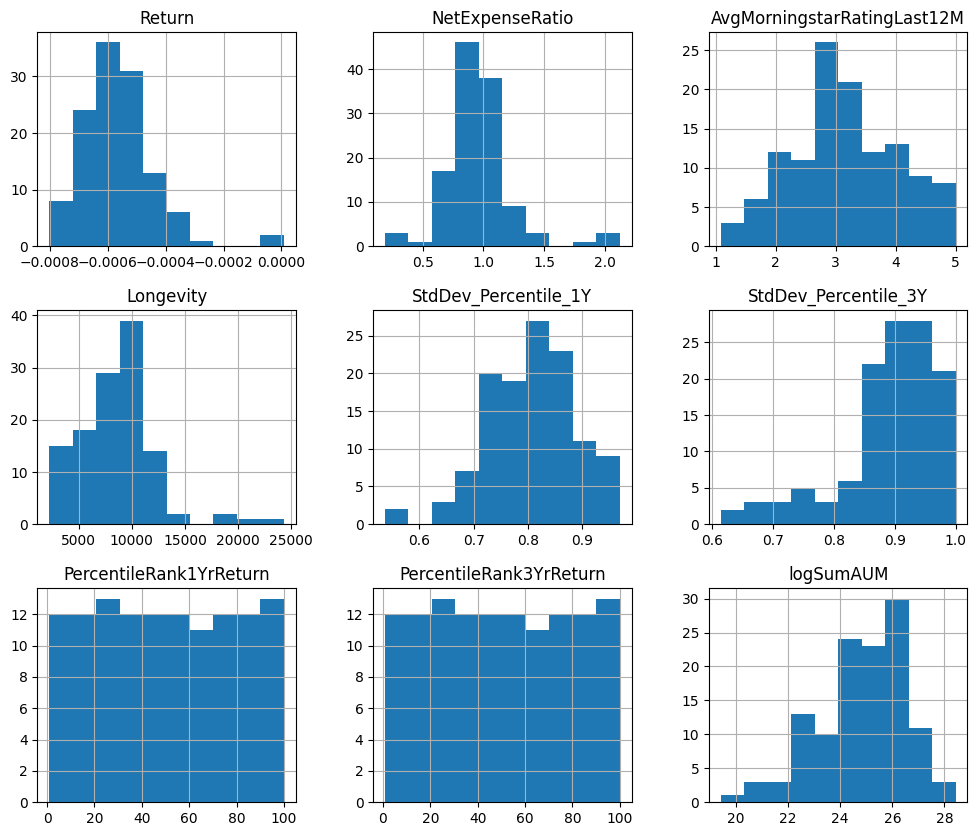

In [0]:
X_2.hist(figsize=(12, 10), layout=(3, 3))


In [0]:
#X_2.columns
X_2['logSumAUM'] = np.log(X_2['SumAUM'] + 1)

In [0]:
X_2.drop(columns='SumAUM', inplace=True)


In [0]:
X_2

,Return,NetExpenseRatio,AvgMorningstarRatingLast12M,Longevity,StdDev_Percentile_1Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn,logSumAUM
15217,-0.000603,0.76,3.583333,19680,0.881977,0.939226,4.132231,21.487603,26.183905
1700,-0.000661,0.94,3.666667,9229,0.843433,0.974364,85.123967,90.909091,22.599423
12059,-0.000526,0.86,3.666667,4441,0.782539,0.832317,81.818182,88.429752,22.995584
3166,-0.000579,0.97,2.583333,8380,0.848392,0.946098,58.677686,33.884298,25.615108
9085,-0.000587,0.60,2.500000,4923,0.896259,0.936895,92.561983,73.553719,24.319345
...,...,...,...,...,...,...,...,...,...
14625,-0.000565,1.05,3.250000,13172,0.845763,0.969224,3.305785,18.181818,25.924654
2494,-0.000526,1.24,3.333333,10592,0.754631,0.789650,88.429752,93.388430,23.413869
1532,-0.000498,1.25,4.250000,8405,0.834230,0.919147,85.950413,85.950413,25.298133
1080,-0.000633,1.09,3.000000,11048,0.801482,0.889865,24.793388,13.223140,22.340456


In [0]:
# normalized X
X_scale = StandardScaler().fit_transform(X_2)

In [0]:
X_2

,Return,NetExpenseRatio,AvgMorningstarRatingLast12M,Longevity,SumAUM,StdDev_Percentile_1Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn,logSumAUM
15217,-0.000603,0.76,3.583333,19680,2.352477e+11,0.881977,0.939226,4.132231,21.487603,26.183905
1700,-0.000661,0.94,3.666667,9229,6.528369e+09,0.843433,0.974364,85.123967,90.909091,22.599423
12059,-0.000526,0.86,3.666667,4441,9.701862e+09,0.782539,0.832317,81.818182,88.429752,22.995584
3166,-0.000579,0.97,2.583333,8380,1.331987e+11,0.848392,0.946098,58.677686,33.884298,25.615108
9085,-0.000587,0.60,2.500000,4923,3.645503e+10,0.896259,0.936895,92.561983,73.553719,24.319345
...,...,...,...,...,...,...,...,...,...,...
14625,-0.000565,1.05,3.250000,13172,1.815240e+11,0.845763,0.969224,3.305785,18.181818,25.924654
2494,-0.000526,1.24,3.333333,10592,1.474057e+10,0.754631,0.789650,88.429752,93.388430,23.413869
1532,-0.000498,1.25,4.250000,8405,9.701512e+10,0.834230,0.919147,85.950413,85.950413,25.298133
1080,-0.000633,1.09,3.000000,11048,5.038910e+09,0.801482,0.889865,24.793388,13.223140,22.340456


#Clustering

## t-sne
[t-sne explanation](https://distill.pub/2016/misread-tsne/)

In [0]:
# a small perplexity can generate more well-separated results
tsne = TSNE(n_components=2, random_state=42, perplexity = 30)
projections = tsne.fit_transform(X_scale)
projections

fig = px.scatter(
    projections,x=0,y=1,
    color=dataset_for_clustering.Fund
)
fig.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9f1e43e840>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

In [0]:
tsne = TSNE(n_components=3, random_state=42, perplexity=13)
projections = tsne.fit_transform(X_scale,)

fig = px.scatter_3d(
    projections,x=0,y=1,z=2,
    color=dataset_for_clustering.Fund
)
fig.show()

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

### Agglomerative Clustering


 - It doesn't require to specify the number of clusters in advance (although you can).
 - It's particularly adept at revealing hierarchical structures within the data, which could be insightful given the nature of financial products.
 - It can accommodate the mixed data types (continuous and binary variables) that come from feature engineering.

In [0]:
from sklearn.decomposition import PCA

# Create PCA object
pca = PCA()

# Fit the PCA model on the scaled data
pca.fit(X_scale)

# Transform the data into the new coordinate system defined by the principal components
X_pca = pca.transform(X_scale)

# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Print out the saying of each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Component {i+1}: {ratio:.2%} of the variance")

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Component 1: 26.49% of the variance
Component 2: 23.87% of the variance
Component 3: 14.78% of the variance
Component 4: 9.37% of the variance
Component 5: 9.14% of the variance
Component 6: 8.32% of the variance
Component 7: 3.44% of the variance
Component 8: 2.83% of the variance
Component 9: 1.76% of the variance


In [0]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scale)

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.20705786784637475


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 3 The average silhouette_score is : 0.22310915942282444


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 4 The average silhouette_score is : 0.21465980139691435


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 5 The average silhouette_score is : 0.2187834315789589


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 6 The average silhouette_score is : 0.2392858169586505


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 7 The average silhouette_score is : 0.233733804817528


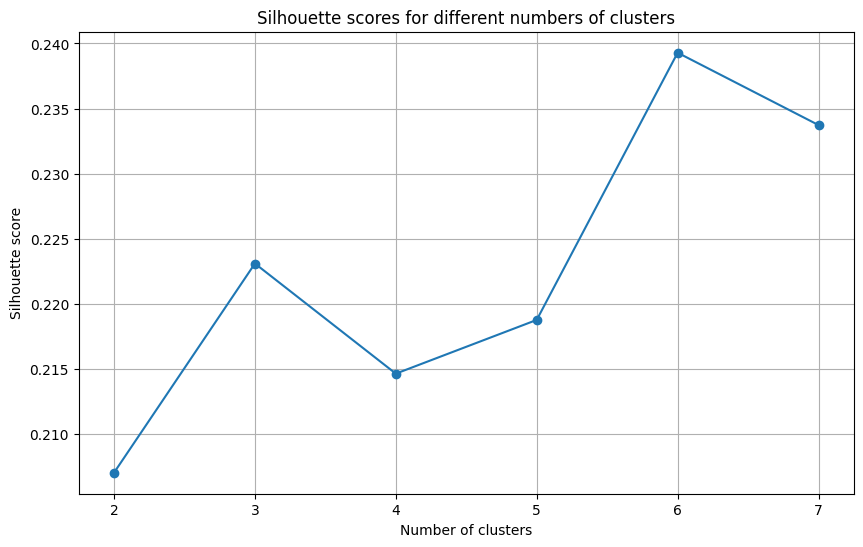

The optimal number of clusters is: 6


In [0]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt


silhouette_scores = []
range_n_clusters = list(range(2,8))  

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and fit it
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.show()

# The optimal cluster number is the one with the highest silhouette score
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print("The optimal number of clusters is:", optimal_n_clusters)


In [0]:
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px

n_clusters = 6
# Perform Agglomerative Clustering on t-SNE projections
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_clusters = agg_clustering.fit_predict(projections)

# Convert projections and cluster labels into a DataFrame for visualization
import pandas as pd
df_clusters = pd.DataFrame(projections, columns=['x', 'y', 'z'])
df_clusters['cluster'] = agg_clusters

fig = px.scatter_3d(df_clusters, x='x', y='y', z='z',
                    color='cluster',
                    color_continuous_scale=px.colors.qualitative.Plotly,
                    opacity=0.8)  # Adjust opacity as needed
fig.show()


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

In [0]:
# from sklearn.cluster import AgglomerativeClustering
# import plotly.express as px

# n_clusters = 3 

# # Perform Agglomerative Clustering on t-SNE projections
# agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
# agg_clusters = agg_clustering.fit_predict(projections)

# # Convert projections and cluster labels into a DataFrame for visualization
# import pandas as pd
# df_clusters = pd.DataFrame(projections, columns=['x', 'y', 'z'])
# df_clusters['cluster'] = agg_clusters

# # Now visualize the clustering results with Plotly
# fig = px.scatter_3d(df_clusters, x='x', y='y', z='z',
#                     color='cluster',
#                     color_discrete_sequence=px.colors.qualitative.Plotly)
#                     #color_continuous_scale=px.colors.qualitative.D3)  # or any other color scale you prefer
# fig.show()

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

In [0]:
X_scale

array([[-0.28351142, -0.73765145,  0.44626741, ..., -1.60327534,
        -1.00204709,  0.80577713],
       [-0.74614331, -0.0797461 ,  0.53936802, ...,  1.2024565 ,
         1.40286592, -1.36743142],
       [ 0.31523585, -0.37214848,  0.53936802, ...,  1.08793684,
         1.31697617, -1.12724612],
       ...,
       [ 0.53517805,  1.05331311,  1.19107232, ...,  1.23108642,
         1.23108642,  0.26874904],
       [-0.52473074,  0.46850835, -0.20543689, ..., -0.88752742,
        -1.28834625, -1.52443884],
       [-0.08817236,  0.10300538,  0.91177048, ...,  0.31492908,
         1.08793684,  0.31574531]])

In [0]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Assuming X_scale is a NumPy array
# Convert it to a DataFrame with explicit column names
# Adjust the column names according to the number of features
column_names = [f'Feature{i + 1}' for i in range(X_scale.shape[1])]
X_scale_df = pd.DataFrame(X_scale, columns=column_names)

# Initialize the Agglomerative Clustering model
n_clusters = 3  # Adjust based on your requirements
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Fit and predict clusters
cluster_labels = agglomerative_clustering.fit_predict(X_scale_df)

# Add the cluster labels to the DataFrame
X_scale_df['Cluster'] = cluster_labels

# Specify the feature indices or column names explicitly
x_feature = 'Feature1'
y_feature = 'Feature2'
z_feature = 'Feature3'

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_scale_df[x_feature], X_scale_df[y_feature], X_scale_df[z_feature],
                     c=X_scale_df['Cluster'], cmap='viridis', s=50)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()


In [0]:
dataset_for_clustering

,NetFlows,Return,Fund,NetExpenseRatio,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,StdDev_Percentile_1Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn
0,-9.711233e+07,-0.000603,AB Small Cap Growth Portfolio,0.76,3.583333,19680,2.352477e+11,2.172774e+09,0.881977,0.939226,4.132231,21.487603
1,2.743296e+06,-0.000661,AMG Frontier Small Cap Growth Fund,0.94,3.666667,9229,6.528369e+09,-7.851459e+07,0.843433,0.974364,85.123967,90.909091
2,1.326032e+05,-0.000526,AMG GW&K Small/Mid Cap Growth Fund,0.86,3.666667,4441,9.701862e+09,-1.233059e+07,0.782539,0.832317,81.818182,88.429752
3,-2.522763e+07,-0.000579,AMG TimesSquare Small Cap Growth Fund,0.97,2.583333,8380,1.331987e+11,-1.525047e+09,0.848392,0.946098,58.677686,33.884298
4,-4.017898e+06,-0.000587,AQR Small Cap Momentum Style Fund,0.60,2.500000,4923,3.645503e+10,-1.973651e+08,0.896259,0.936895,92.561983,73.553719
...,...,...,...,...,...,...,...,...,...,...,...,...
116,-4.188961e+07,-0.000565,Wasatch Small Cap Growth Fund®,1.05,3.250000,13172,1.815240e+11,-1.042864e+09,0.845763,0.969224,3.305785,18.181818
117,9.502704e+05,-0.000526,WesMark Small Company Fund,1.24,3.333333,10592,1.474057e+10,1.024386e+06,0.754631,0.789650,88.429752,93.388430
118,-2.985949e+06,-0.000498,William Blair Small Cap Growth Fund,1.25,4.250000,8405,9.701512e+10,-8.660315e+08,0.834230,0.919147,85.950413,85.950413
119,-7.343363e+05,-0.000633,Wilshire Small Company Growth Portfolio,1.09,3.000000,11048,5.038910e+09,-1.869129e+07,0.801482,0.889865,24.793388,13.223140


In [0]:
df_clusters

,x,y,z,cluster
0,-7.475604,-72.733742,-54.092575,4
1,16.480768,55.220718,-7.603239,0
2,-7.040314,65.648979,-31.250732,0
3,-36.972145,-3.376190,-7.030100,3
4,-32.422001,71.125175,16.204273,0
...,...,...,...,...
116,-12.902519,-49.042179,-61.908302,1
117,59.519535,38.447956,46.974087,0
118,42.785934,21.687096,20.397198,2
119,-23.057217,23.800886,-47.993210,3


In [0]:

# Resetting index if needed
dataset_for_clustering = dataset_for_clustering.reset_index(drop=True)
df_clusters = df_clusters.reset_index(drop=True)

# Concatenating after resetting indices
joined_df = pd.concat([dataset_for_clustering, df_clusters[['cluster']]], axis=1)
joined_df.head()


,NetFlows,Return,Fund,NetExpenseRatio,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,StdDev_Percentile_1Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn,cluster
0,-9.711233e+07,-0.000603,AB Small Cap Growth Portfolio,0.76,3.583333,19680,2.352477e+11,2.172774e+09,0.881977,0.939226,4.132231,21.487603,4
1,2.743296e+06,-0.000661,AMG Frontier Small Cap Growth Fund,0.94,3.666667,9229,6.528369e+09,-7.851459e+07,0.843433,0.974364,85.123967,90.909091,0
2,1.326032e+05,-0.000526,AMG GW&K Small/Mid Cap Growth Fund,0.86,3.666667,4441,9.701862e+09,-1.233059e+07,0.782539,0.832317,81.818182,88.429752,0
3,-2.522763e+07,-0.000579,AMG TimesSquare Small Cap Growth Fund,0.97,2.583333,8380,1.331987e+11,-1.525047e+09,0.848392,0.946098,58.677686,33.884298,3
4,-4.017898e+06,-0.000587,AQR Small Cap Momentum Style Fund,0.60,2.500000,4923,3.645503e+10,-1.973651e+08,0.896259,0.936895,92.561983,73.553719,0


In [0]:
import pandas as pd


# Define the quartile labels. The highest values will be in Q1, the lowest in Q4.
quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Use qcut to assign each 'SumNetFlows' value to a quartile, with quartile labels
joined_df['Quartile'] = pd.qcut(joined_df['SumNetFlows'], 4, labels=quartile_labels[::-1])

# The DataFrame now has a 'Quartile' column with the quartile group for each row
joined_df.head()


,NetFlows,Return,Fund,NetExpenseRatio,AvgMorningstarRatingLast12M,Longevity,SumAUM,SumNetFlows,StdDev_Percentile_1Y,StdDev_Percentile_3Y,PercentileRank1YrReturn,PercentileRank3YrReturn,cluster,Quartile
0,-9.711233e+07,-0.000603,AB Small Cap Growth Portfolio,0.76,3.583333,19680,2.352477e+11,2.172774e+09,0.881977,0.939226,4.132231,21.487603,4,Q1
1,2.743296e+06,-0.000661,AMG Frontier Small Cap Growth Fund,0.94,3.666667,9229,6.528369e+09,-7.851459e+07,0.843433,0.974364,85.123967,90.909091,0,Q2
2,1.326032e+05,-0.000526,AMG GW&K Small/Mid Cap Growth Fund,0.86,3.666667,4441,9.701862e+09,-1.233059e+07,0.782539,0.832317,81.818182,88.429752,0,Q2
3,-2.522763e+07,-0.000579,AMG TimesSquare Small Cap Growth Fund,0.97,2.583333,8380,1.331987e+11,-1.525047e+09,0.848392,0.946098,58.677686,33.884298,3,Q4
4,-4.017898e+06,-0.000587,AQR Small Cap Momentum Style Fund,0.60,2.500000,4923,3.645503e+10,-1.973651e+08,0.896259,0.936895,92.561983,73.553719,0,Q3


In [0]:
# Assuming 'joined_df' contains a 'cluster' column
# Count the number of rows in each cluster
cluster_counts = joined_df['cluster'].value_counts()
cluster_percentages = joined_df['cluster'].value_counts(normalize=True) * 100

# Combine the counts and percentages into a DataFrame
cluster_summary = pd.DataFrame({'Count': cluster_counts, 'Percentage (%)': cluster_percentages.round(2)})

# Print the summary DataFrame
print(cluster_summary)


         Count  Percentage (%)
cluster                       
3           25           20.66
1           24           19.83
0           22           18.18
2           19           15.70
4           16           13.22
5           15           12.40


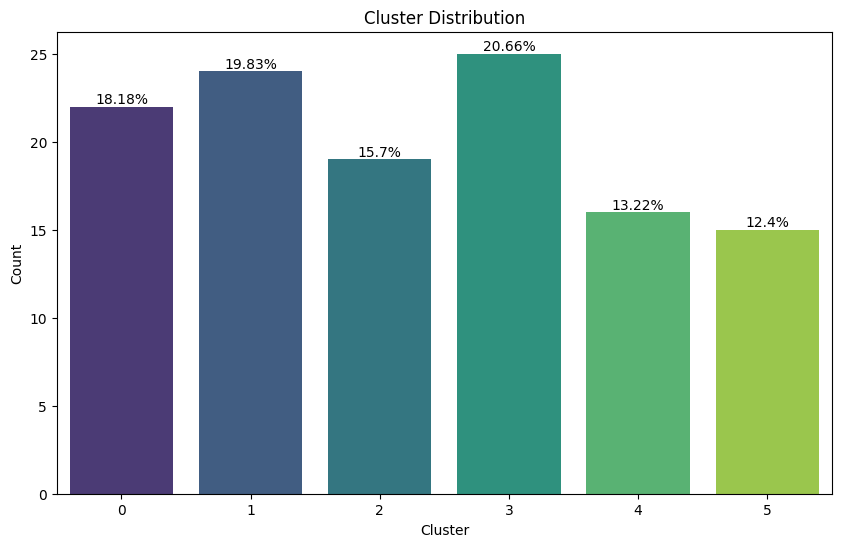

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'joined_df' contains a 'cluster' column
# Count the number of rows in each cluster and calculate percentages
cluster_counts = joined_df['cluster'].value_counts()
cluster_percentages = joined_df['cluster'].value_counts(normalize=True) * 100

# Combine the counts and percentages into a DataFrame and round percentages to 2 decimal places
cluster_summary = pd.DataFrame({'Count': cluster_counts, 'Percentage (%)': cluster_percentages.round(2)})

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_summary.index, y='Count', data=cluster_summary, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')

# Annotate bars with percentages
for index, row in cluster_summary.iterrows():
    plt.text(index, row['Count'], f"{row['Percentage (%)']}%", color='black', ha="center", va="bottom")

#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Figure size 1000x600 with 0 Axes>

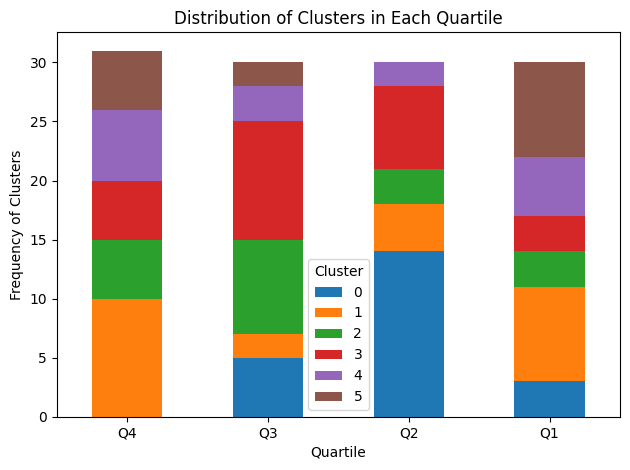

In [0]:
cluster_distribution = joined_df.groupby('Quartile')['cluster'].value_counts().unstack(fill_value=0)

# Plotting the distribution of clusters in each quartile
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind='bar', stacked=True)
plt.title('Distribution of Clusters in Each Quartile')
plt.xlabel('Quartile')
plt.ylabel('Frequency of Clusters')
plt.xticks(rotation=0)  # Keep the Quartile labels horizontal
plt.legend(title='Cluster')
plt.tight_layout()

In [0]:
distribution = (joined_df.groupby('cluster')['Quartile']
                            .value_counts(normalize=True)  # This computes the relative frequencies
                             # Converts fractions to percentages
                            .unstack(fill_value=0))
distribution

Quartile,Q4,Q3,Q2,Q1
cluster,,,,
0,0.000000,0.227273,0.636364,0.136364
1,0.416667,0.083333,0.166667,0.333333
2,0.263158,0.421053,0.157895,0.157895
3,0.200000,0.400000,0.280000,0.120000
4,0.375000,0.187500,0.125000,0.312500
5,0.333333,0.133333,0.000000,0.533333


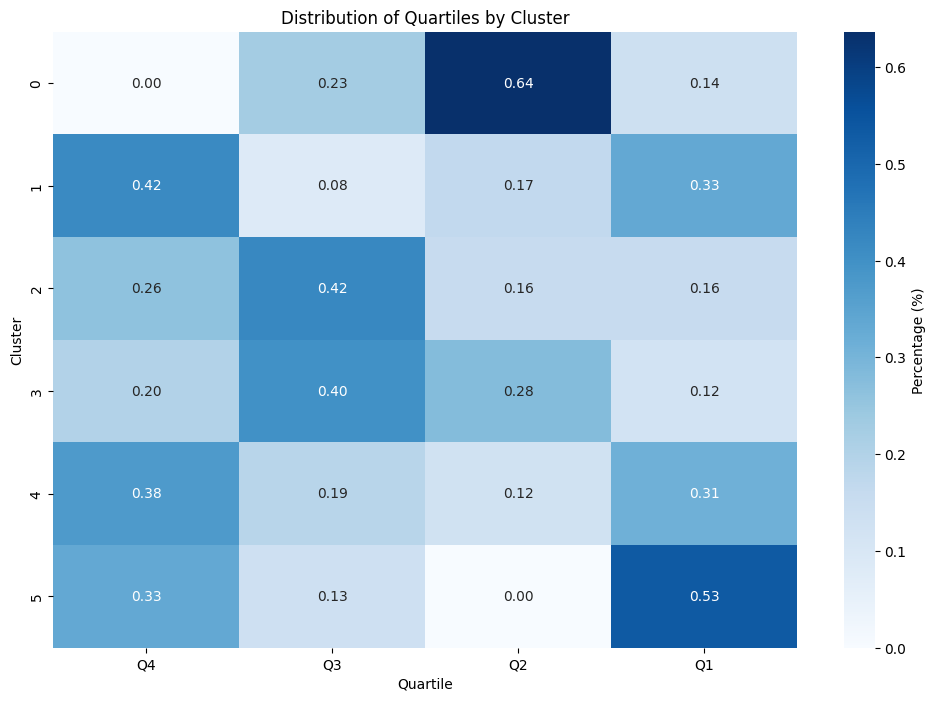

In [0]:
# Plot the distribution of quartiles per cluster
plt.figure(figsize=(12, 8))
sns.heatmap(distribution, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'label': 'Percentage (%)'})
plt.xlabel('Quartile')
plt.ylabel('Cluster')
plt.title('Distribution of Quartiles by Cluster')
plt.show()

In [0]:
calamos_rows = joined_df[joined_df['Fund'].str.contains('calamos', case=False)]
calamos_rows[['Fund','cluster']]

,Fund,cluster
23,Calamos Timpani Small Cap Growth Fund,1


In [0]:
calamos_rows = joined_df[joined_df['Fund'].str.contains('JP', case=False)]
calamos_rows[['Fund','cluster']]

,Fund,cluster
59,JPMorgan Small Cap Growth Fund,4


Cluster 4 Descriptive Statistics:
            NetFlows     Return  ...  PercentileRank3YrReturn  cluster
count  1.600000e+01  16.000000  ...                16.000000     16.0
mean  -6.841628e+07  -0.000575  ...                27.892562      4.0
std    9.019519e+07   0.000123  ...                26.011404      0.0
min   -3.156862e+08  -0.000800  ...                 2.479339      4.0
25%   -6.828933e+07  -0.000632  ...                11.983471      4.0
50%   -3.787163e+07  -0.000593  ...                18.595041      4.0
75%   -1.339238e+07  -0.000475  ...                30.165289      4.0
max    1.292300e+07  -0.000359  ...                85.123967      4.0

[8 rows x 12 columns]


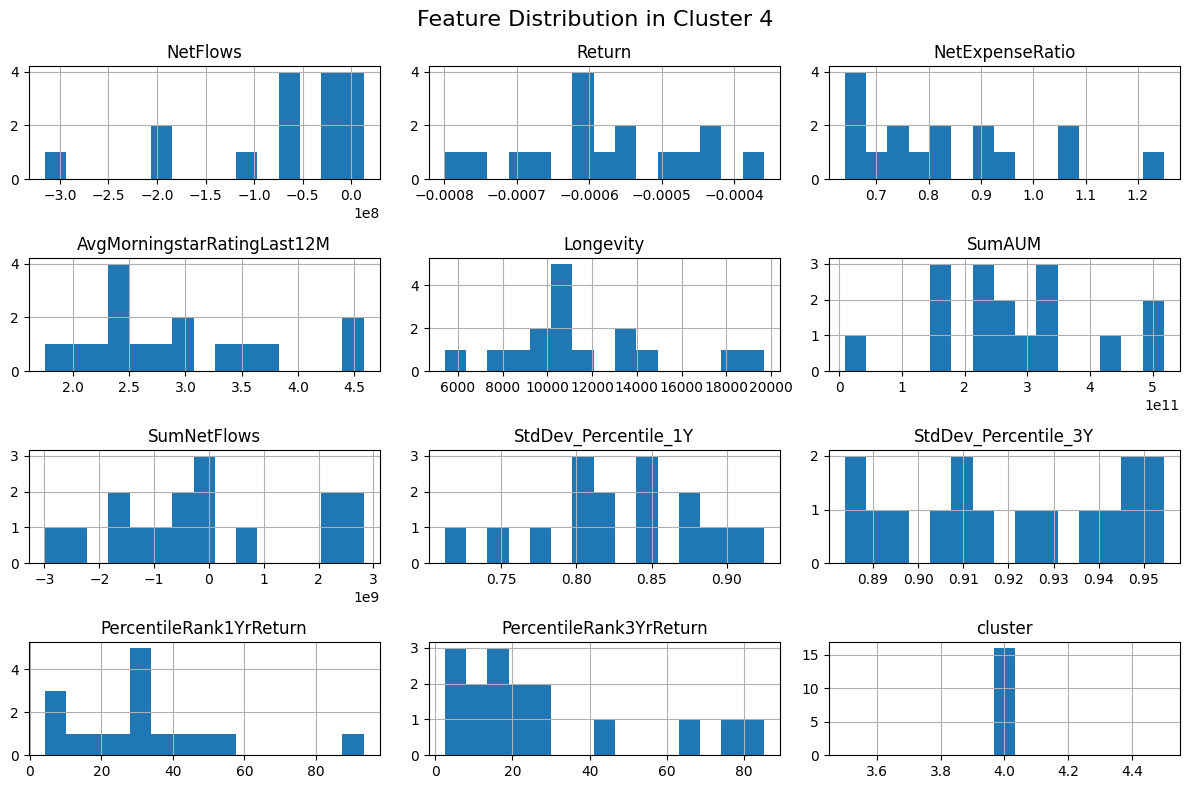

In [0]:

# Filter to Cluster 4
cluster4_data = joined_df[joined_df['cluster'] == 4]

# Basic Descriptive Statistics
cluster4_description = cluster4_data.describe()
print("Cluster 4 Descriptive Statistics:\n", cluster4_description)

# Feature Distribution Analysis (use histograms or box plots)
cluster4_data.hist(figsize=(12, 8), bins=15)
plt.suptitle('Feature Distribution in Cluster 4', fontsize=16)
plt.tight_layout()
plt.show()

Cluster 4 Descriptive Statistics:
            NetFlows     Return  ...  PercentileRank3YrReturn  cluster
count  2.400000e+01  24.000000  ...                24.000000     24.0
mean  -1.408451e+07  -0.000648  ...                43.663912      1.0
std    1.963474e+07   0.000093  ...                27.372900      0.0
min   -5.891356e+07  -0.000803  ...                 0.826446      1.0
25%   -2.027870e+07  -0.000701  ...                18.801653      1.0
50%   -5.923115e+06  -0.000667  ...                48.760331      1.0
75%   -6.380971e+05  -0.000619  ...                66.322314      1.0
max    7.502173e+06  -0.000414  ...                90.082645      1.0

[8 rows x 12 columns]


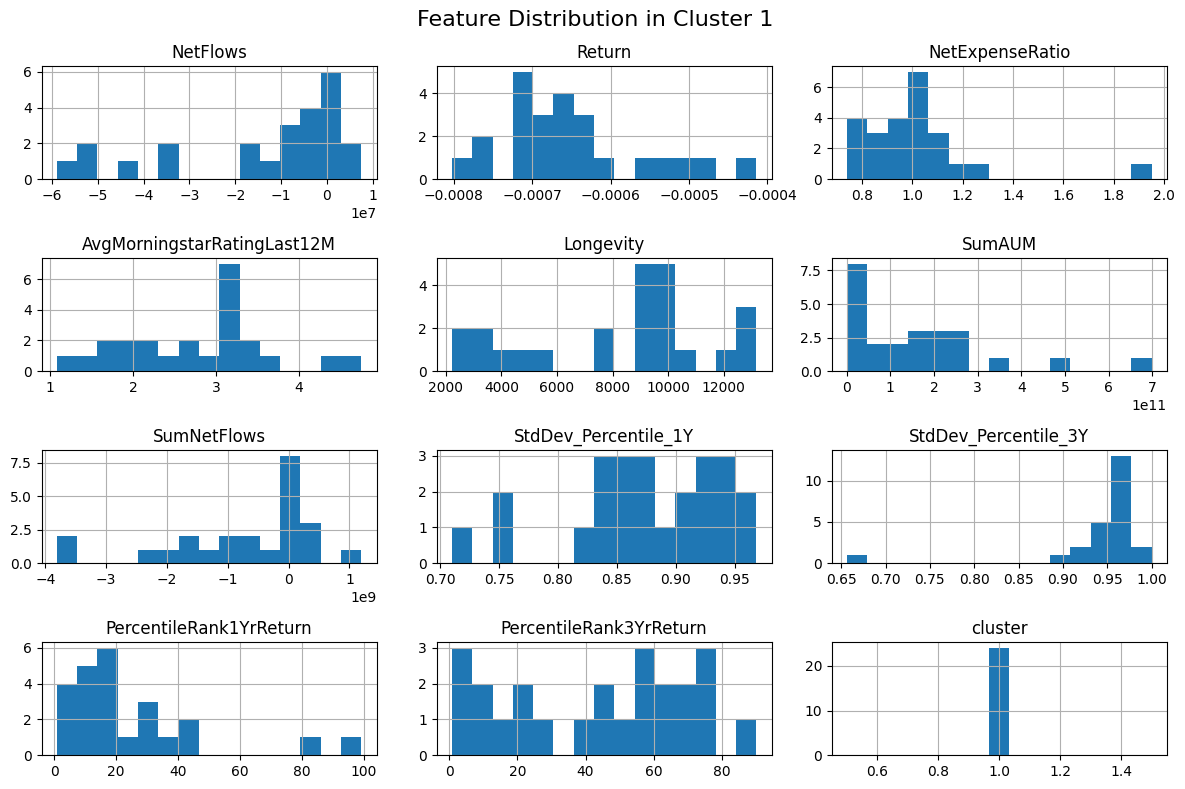

In [0]:
# Filter to Cluster 4
cluster4_data = joined_df[joined_df['cluster'] == 1]

# Basic Descriptive Statistics
cluster4_description = cluster4_data.describe()
print("Cluster 4 Descriptive Statistics:\n", cluster4_description)

# Feature Distribution Analysis (use histograms or box plots)
cluster4_data.hist(figsize=(12, 8), bins=15)
plt.suptitle('Feature Distribution in Cluster 1', fontsize=16)
plt.tight_layout()
plt.show()